# CUSTOMER SEGMENTATION: CREDIT CARD USAGE ANALYSIS

**Objective:**
Develop a comprehensive customer clustering pipeline to group credit card holders based on their buying habits, payments, and credit usage. This analysis compares three major clustering algorithms: **K-Means**, **Hierarchical Clustering**, and **DBSCAN**.

**Workflow:**
1. **Data Loading:** Automated download via Gdown.
2. **Data Cleaning & Preprocessing:** Handling missing values, Log-transformation, and Scaling.
3. **Dimensionality Reduction:** PCA for visualization.
4. **Modeling & Comparison:**
    * **K-Means Clustering** (Partition-based)
    * **Hierarchical Clustering** (Connectivity-based)
    * **DBSCAN** (Density-based)
5. **Evaluation & Profiling:** Analyzing cluster characteristics to define customer personas.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import os
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
np.random.seed(42)
plt.style.use('ggplot')

print("\n✓ Libraries imported successfully!")


✓ Libraries imported successfully!


## 1. Data Loading

In [22]:
print(f"\n{'─'*50}")
print("PHASE 1: DATA INGESTION")
print(f"{'─'*50}")

output_file = 'clusteringmidterm.csv'
file_id = '1XtaKeD7b-la2R1ygFBNLj16VD1k0MB2Q'
url = f'https://drive.google.com/uc?id={file_id}'

if not os.path.exists(output_file):
    print(f"• Downloading dataset from Google Drive...")
    gdown.download(url, output_file, quiet=False)
    print("✓ Download complete.")
else:
    print("✓ Dataset already exists locally.")

# Load Data
df = pd.read_csv(output_file)

print(f"\n• Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print("• First 5 rows preview:")
display(df.head())


──────────────────────────────────────────────────
PHASE 1: DATA INGESTION
──────────────────────────────────────────────────
✓ Dataset already exists locally.

• Dataset Shape: 8950 rows, 18 columns
• First 5 rows preview:


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## 2. Data Inspection & Cleaning
Check for missing values and remove non-informative columns like `CUST_ID`.

In [23]:
print(f"\n{'─'*50}")
print("PHASE 2: DATA INSPECTION & CLEANING")
print(f"{'─'*50}")

# 2.1 Check for Missing Values
missing = df.isnull().sum()
missing = missing[missing > 0]
if len(missing) > 0:
    print("\nMissing Values Found:")
    print(missing)
    # Impute missing values with Median
    df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), inplace=True)
    df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].median(), inplace=True)
    print("✓ Missing values imputed with Median.")
else:
    print("✓ No missing values found.")

# 2.2 Drop ID Column
if 'CUST_ID' in df.columns:
    df.drop('CUST_ID', axis=1, inplace=True)
    print("✓ Dropped 'CUST_ID' column.")

# 2.3 Duplicate Check
dupes = df.duplicated().sum()
if dupes > 0:
    df.drop_duplicates(inplace=True)
    print(f"✓ Dropped {dupes} duplicate rows.")
else:
    print("✓ No duplicates found.")


──────────────────────────────────────────────────
PHASE 2: DATA INSPECTION & CLEANING
──────────────────────────────────────────────────

Missing Values Found:
CREDIT_LIMIT          1
MINIMUM_PAYMENTS    313
dtype: int64
✓ Missing values imputed with Median.
✓ Dropped 'CUST_ID' column.
✓ No duplicates found.


## 3. Exploratory Data Analysis & Preprocessing
Financial data is often skewed. Apply **Log Transformation** to normalize distributions and then **Standard Scaling**.


──────────────────────────────────────────────────
PHASE 3: EDA & PREPROCESSING
──────────────────────────────────────────────────


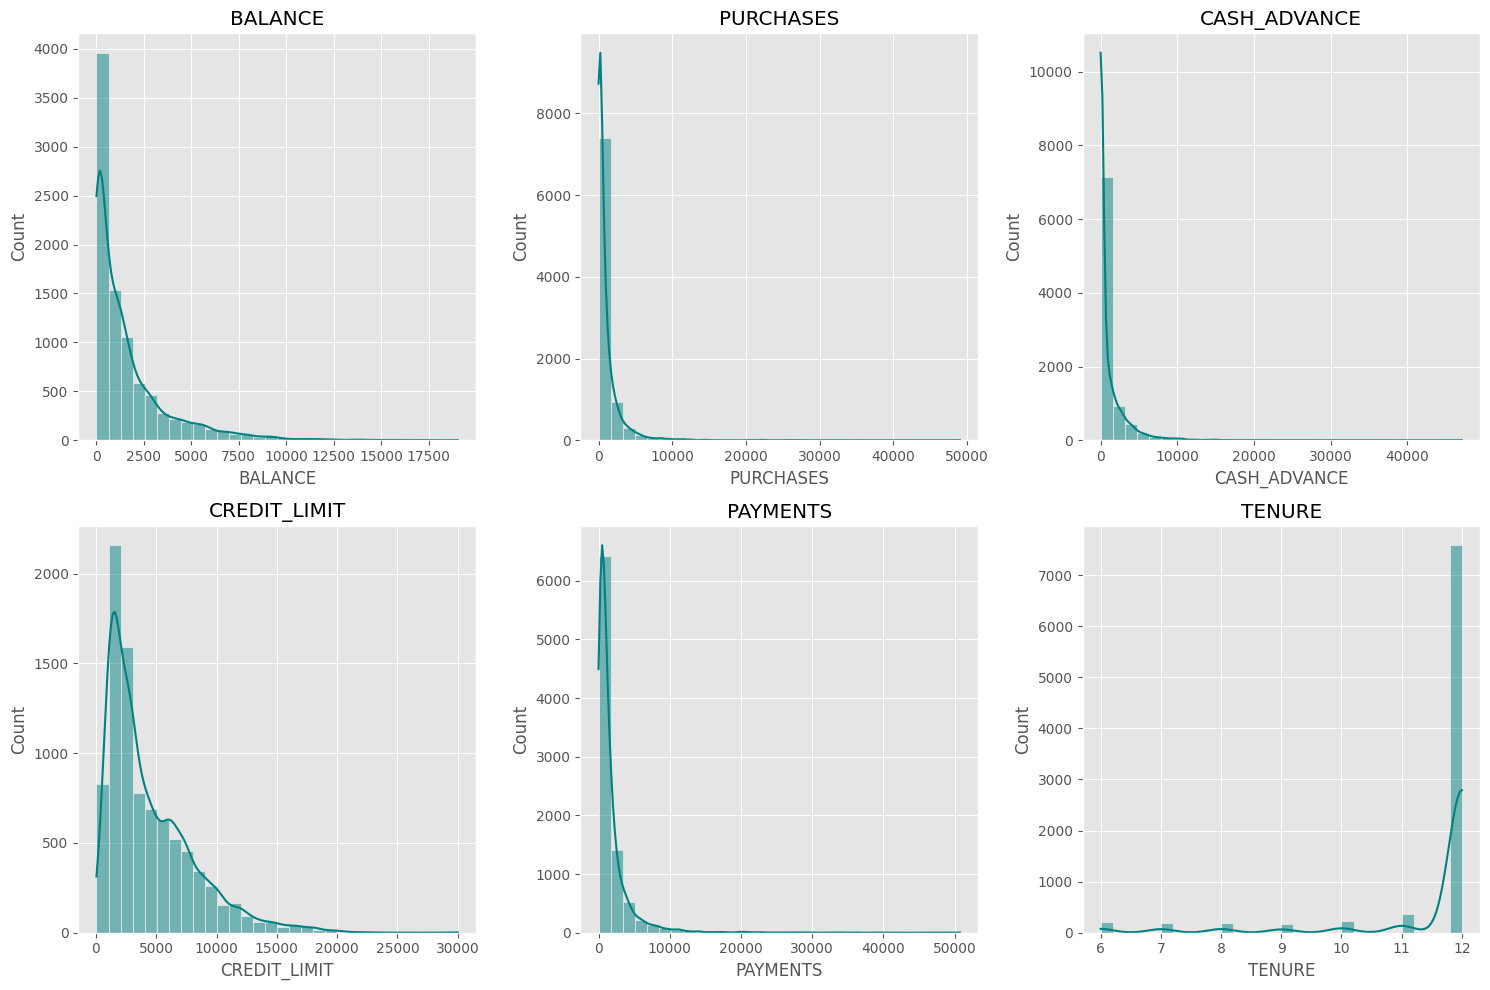

✓ Log transformation applied.
✓ Data scaled (StandardScaler).


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-1.205218,-0.148757,-0.113532,-0.987090,0.394480,-0.930733,-0.746901,-0.732480,-0.674253,-0.724360,-0.810069,-0.579510,-1.447163,-0.824484,-0.829841,-0.556368,0.347262
1,0.948918,0.179616,-1.679855,-0.987090,-1.087454,1.528788,-1.302799,-0.732480,-0.958256,0.699592,0.784603,-1.379210,0.926060,1.065033,0.908184,0.391958,0.347262
2,0.824993,0.492710,0.600727,1.062022,-1.087454,-0.930733,1.196820,2.466762,-0.958256,-0.724360,-0.810069,0.487865,1.010229,-0.119300,0.450407,-0.556368,0.347262
3,0.624653,-0.857867,0.827499,1.265778,-1.087454,0.564372,-1.014151,-0.363042,-0.958256,-0.213583,-0.123281,-0.874655,1.010229,-4.161996,-0.144271,-0.556368,0.347262
4,0.271260,0.492710,-0.708481,-0.114307,-1.087454,-0.930733,-1.014151,-0.363042,-0.958256,-0.724360,-0.810069,-0.874655,-1.224909,-0.064979,-0.351833,-0.556368,0.347262


In [24]:
print(f"\n{'─'*50}")
print("PHASE 3: EDA & PREPROCESSING")
print(f"{'─'*50}")

# 3.1 Distribution Visualization
plt.figure(figsize=(15, 10))
features_to_plot = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'TENURE']
for i, col in enumerate(features_to_plot):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], kde=True, bins=30, color='teal')
    plt.title(col)
plt.tight_layout()
plt.show()

# 3.2 Log Transformation
df_log = df.apply(lambda x: np.log1p(x))
print("✓ Log transformation applied.")

# 3.3 Scaling
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_log)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
print("✓ Data scaled (StandardScaler).")
display(df_scaled.head())

## 4. Dimensionality Reduction (PCA)
Reduce dimensions to 2 components for visualization purposes.

In [25]:
print(f"\n{'─'*50}")
print("PHASE 4: PCA (PRINCIPAL COMPONENT ANALYSIS)")
print(f"{'─'*50}")

pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])

print(f"• Explained Variance: {sum(pca.explained_variance_ratio_)*100:.2f}%")
print("✓ PCA transformation complete.")


──────────────────────────────────────────────────
PHASE 4: PCA (PRINCIPAL COMPONENT ANALYSIS)
──────────────────────────────────────────────────
• Explained Variance: 56.46%
✓ PCA transformation complete.


## 5. Modeling Part 1: K-Means Clustering
Determine the optimal number of clusters (K) using the **Elbow Method** and **Silhouette Score**.


──────────────────────────────────────────────────
PHASE 5: K-MEANS CLUSTERING
──────────────────────────────────────────────────


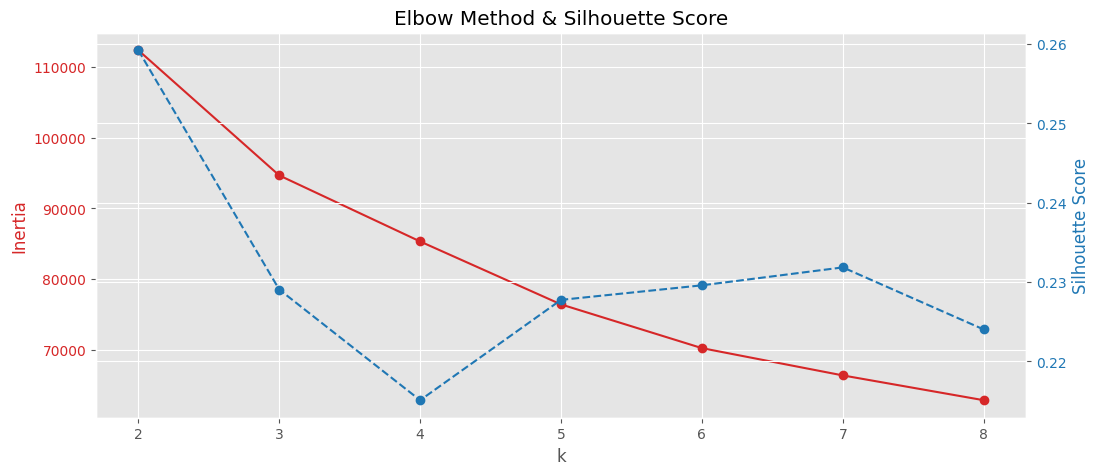

✓ K-Means Model Fitted (K=4).


In [26]:
print(f"\n{'─'*50}")
print("PHASE 5: K-MEANS CLUSTERING")
print(f"{'─'*50}")

inertia = []
silhouette = []
K_range = range(2, 9)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df_scaled, kmeans.labels_))

# Elbow & Silhouette Plot
fig, ax1 = plt.subplots(figsize=(12, 5))
color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(K_range, inertia, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(K_range, silhouette, 'o--', color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Elbow Method & Silhouette Score')
plt.show()

# Fit K-Means with optimal K (e.g., K=4)
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_kmeans = kmeans_final.fit_predict(df_scaled)
print("✓ K-Means Model Fitted (K=4).")

## 6. Modeling Part 2: Hierarchical Clustering
Using a Dendrogram to visualize hierarchical relationships and Agglomerative Clustering.


──────────────────────────────────────────────────
PHASE 6: HIERARCHICAL CLUSTERING
──────────────────────────────────────────────────


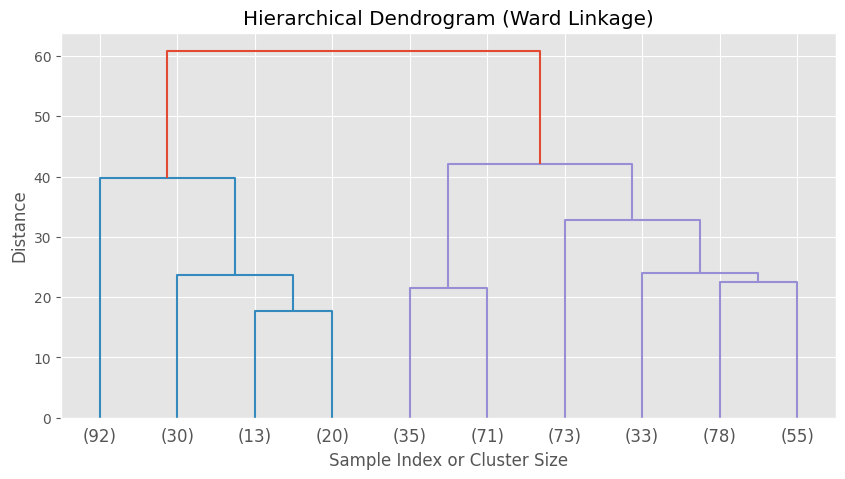

✓ Hierarchical Clustering Fitted (K=4).


In [27]:
print(f"\n{'─'*50}")
print("PHASE 6: HIERARCHICAL CLUSTERING")
print(f"{'─'*50}")

# Dendrogram (on a sample for speed)
plt.figure(figsize=(10, 5))
sample_data = df_scaled[:500]
linked = linkage(sample_data, method='ward')
dendrogram(linked, truncate_mode='lastp', p=10)
plt.title('Hierarchical Dendrogram (Ward Linkage)')
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance')
plt.show()

# Fit Agglomerative Clustering (K=4)
hc = AgglomerativeClustering(n_clusters=4, linkage='ward')
labels_hc = hc.fit_predict(df_scaled)
print("✓ Hierarchical Clustering Fitted (K=4).")

## 7. Modeling Part 3: DBSCAN
Density-Based Spatial Clustering of Applications with Noise. Good for non-spherical clusters.


──────────────────────────────────────────────────
PHASE 7: DBSCAN
──────────────────────────────────────────────────


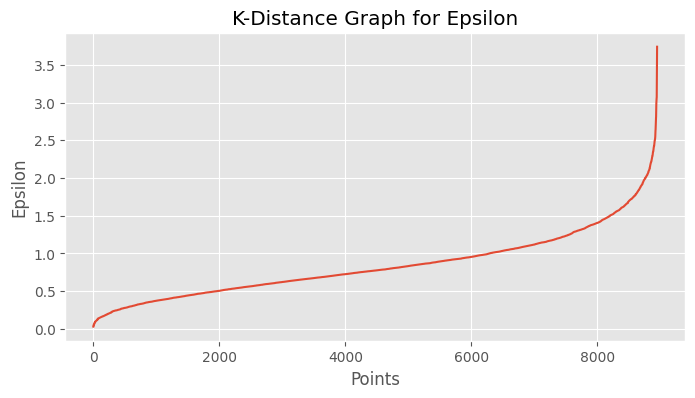

✓ DBSCAN Fitted. Clusters: 4, Noise Points: 692


In [28]:
print(f"\n{'─'*50}")
print("PHASE 7: DBSCAN")
print(f"{'─'*50}")

# Determine optimal epsilon using k-distance graph
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_scaled)
distances, indices = nbrs.kneighbors(df_scaled)
distances = np.sort(distances[:, 1], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title('K-Distance Graph for Epsilon')
plt.ylabel('Epsilon')
plt.xlabel('Points')
plt.show()

# Fit DBSCAN (Adjust eps/min_samples based on graph/data size)
dbscan = DBSCAN(eps=2.0, min_samples=20)
labels_dbscan = dbscan.fit_predict(df_scaled)

n_clusters_ = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_ = list(labels_dbscan).count(-1)
print(f"✓ DBSCAN Fitted. Clusters: {n_clusters_}, Noise Points: {n_noise_}")

## 8. Comparative Visualization
Comparing the results of K-Means, Hierarchical, and DBSCAN on the PCA components.


──────────────────────────────────────────────────
PHASE 8: MODEL COMPARISON
──────────────────────────────────────────────────


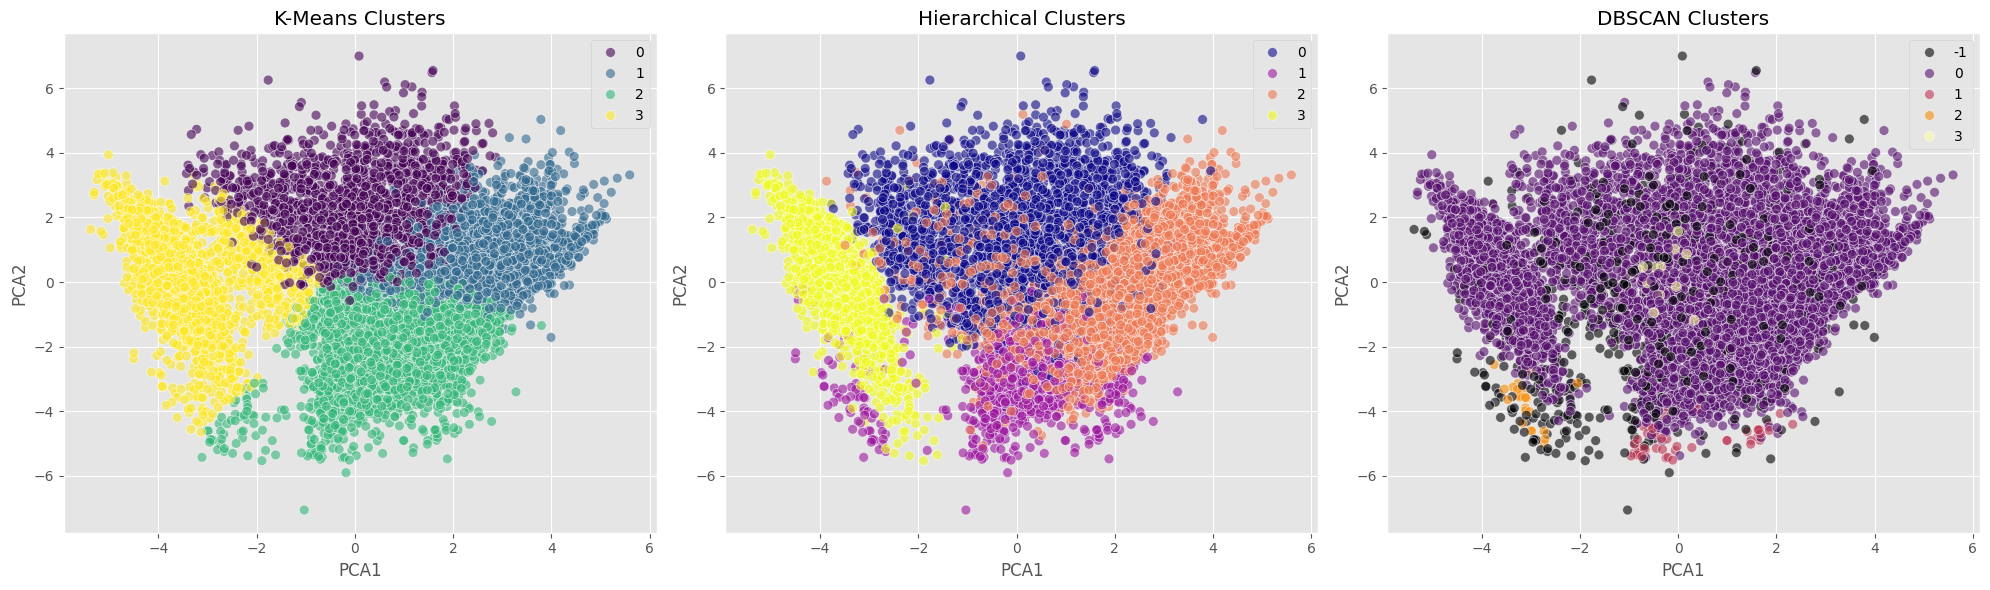

In [29]:
print(f"\n{'─'*50}")
print("PHASE 8: MODEL COMPARISON")
print(f"{'─'*50}")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

models = [('K-Means', labels_kmeans), ('Hierarchical', labels_hc), ('DBSCAN', labels_dbscan)]
cmaps = ['viridis', 'plasma', 'inferno']

for i, (name, labels) in enumerate(models):
    sns.scatterplot(x=df_pca['PCA1'], y=df_pca['PCA2'], hue=labels, palette=cmaps[i], ax=axes[i], s=50, alpha=0.6, legend='full')
    axes[i].set_title(f'{name} Clusters')

plt.tight_layout()
plt.show()

## 9. Cluster Interpretation (Using K-Means)
Select K-Means for profiling as it typically yields well-separated, interpretable business segments for this dataset.


──────────────────────────────────────────────────
PHASE 9: CLUSTER PROFILING (K-Means)
──────────────────────────────────────────────────

Cluster Profiles (Mean Values):


,BALANCE,PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS,Count
Cluster,,,,,,
0,3186.905474,1326.169468,2550.782879,5606.515957,2769.215158,1504
1,1453.234520,2578.807063,40.313486,5938.277517,2492.083090,2206
2,248.750108,442.786175,24.294911,3181.460013,674.157227,2758
3,2142.246465,29.843566,1921.265951,3995.697507,1607.524959,2482


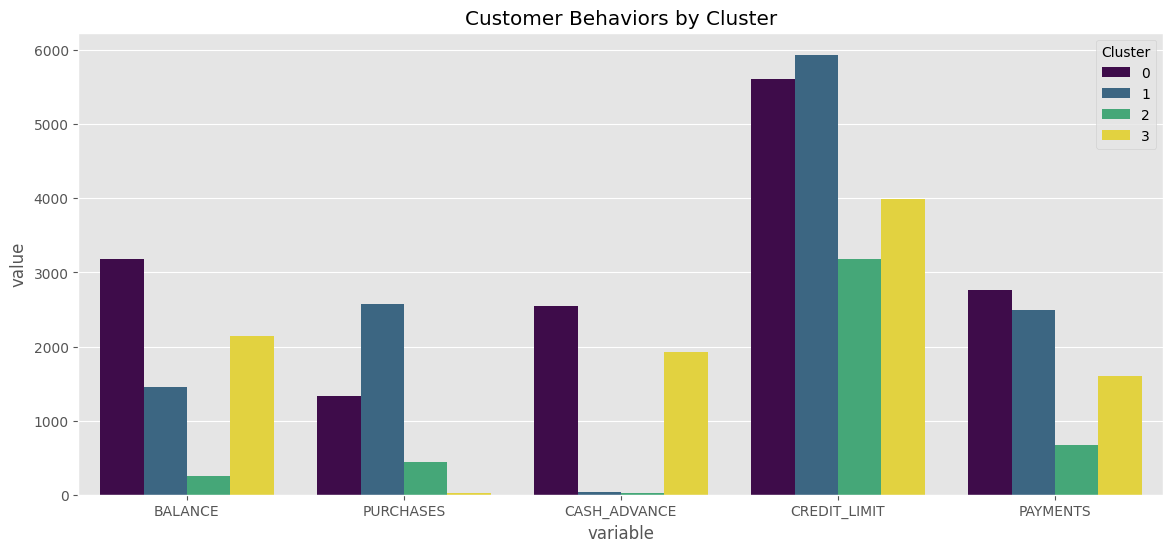

In [30]:
print(f"\n{'─'*50}")
print("PHASE 9: CLUSTER PROFILING (K-Means)")
print(f"{'─'*50}")

df['Cluster'] = labels_kmeans
profile = df.groupby('Cluster')[['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS']].mean()
profile['Count'] = df['Cluster'].value_counts()

print("\nCluster Profiles (Mean Values):")
display(profile.style.background_gradient(cmap='Greens'))

# Barplot Visualization
profile_melt = profile.drop('Count', axis=1).reset_index().melt(id_vars='Cluster')
plt.figure(figsize=(14, 6))
sns.barplot(data=profile_melt, x='variable', y='value', hue='Cluster', palette='viridis')
plt.title('Customer Behaviors by Cluster')
plt.show()

## 10. Executive Summary

In [32]:
print(f"""
{'─'*60}
EXECUTIVE SUMMARY: CUSTOMER PERSONAS
{'─'*60}

Based on K-Means (K=4), Identified distinctive customer segments:

Note: Check the 'Cluster Profiles' table to map these descriptions to specific Cluster IDs (0-3).

1. **The Big Spenders:**
   - High PURCHASE amounts and high CREDIT_LIMIT.
   - *Strategy:* Premium cards, exclusive rewards, luxury partnerships.

2. **The Cash Advancers:**
   - High CASH_ADVANCE frequency and amount. Low purchases.
   - *Strategy:* Promote lower interest installment loans.

3. **The Revolvers (Debt Carriers):**
   - High BALANCE but low PAYMENTS.
   - *Strategy:* Balance transfer offers, credit counseling tools.

4. **The Transactors:**
   - Average/Low balance, frequent small purchases, pays off fully.
   - *Strategy:* Retention via cashback or points on daily spend.
""")


────────────────────────────────────────────────────────────
EXECUTIVE SUMMARY: CUSTOMER PERSONAS
────────────────────────────────────────────────────────────

Based on K-Means (K=4), Identified distinctive customer segments:

Note: Check the 'Cluster Profiles' table to map these descriptions to specific Cluster IDs (0-3).

1. **The Big Spenders:**
   - High PURCHASE amounts and high CREDIT_LIMIT.
   - *Strategy:* Premium cards, exclusive rewards, luxury partnerships.

2. **The Cash Advancers:**
   - High CASH_ADVANCE frequency and amount. Low purchases.
   - *Strategy:* Promote lower interest installment loans.

3. **The Revolvers (Debt Carriers):**
   - High BALANCE but low PAYMENTS.
   - *Strategy:* Balance transfer offers, credit counseling tools.

4. **The Transactors:**
   - Average/Low balance, frequent small purchases, pays off fully.
   - *Strategy:* Retention via cashback or points on daily spend.

